# Fixing problems with the protest news dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

with open(project_root / "data" / "news" / "protest_news_shuffled.jsonl") as f:
    items = [json.loads(line) for line in f]

In [3]:
lengths = [len(a["text"]) for a in items]

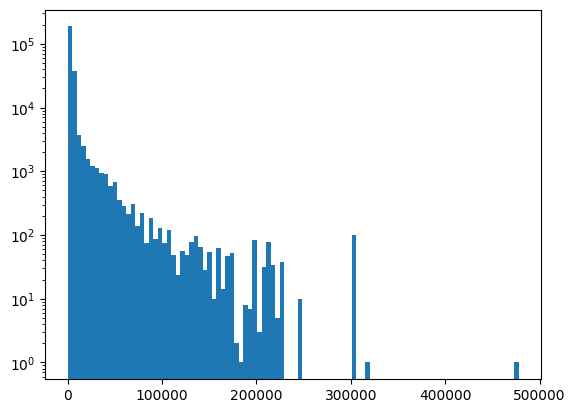

In [4]:
# histogram of lengths
import matplotlib.pyplot as plt

# log y axis
plt.hist(lengths, bins=100, log=True)
plt.show()

# Duplicate problem

In [5]:
len(items)

241472

In [6]:
len({hash(a["text"]) for a in items}) / len(items)

0.5219238669493772

In [7]:
from collections import defaultdict

hashes = defaultdict(list)
for item in items:
    hashes[hash(item["text"])].append(item)

len(hashes)

126030

In [8]:
for hash_, items_ in list(hashes.items())[:10]:
    for item in items_:
        print(item["meta"])
    print()

{'date': '2020-12-01T23:45:00', 'title': 'Schutz: Bannmeile für den Bundestag', 'url': 'https://www.aachener-zeitung.de/politik/deutschland/bannmeile-fuer-den-bundestag_aid-54942695', 'homepage': 'aachener-zeitung.de', 'crawl_engine': 'mediacloud', 'crawl_query': 'protest'}

{'date': '2020-06-25T04:02:19', 'title': 'Netflix entfernt mehrere Animes am 30. September - sowie weitere Inhalte', 'url': 'https://www.op-online.de/film-tv-musik/netflix-entfernt-filme-serien-liste-alle-inhalte-verschwinden-2020-zr-13809817.html?cmp=defrss', 'homepage': 'op-online.de', 'crawl_engine': 'mediacloud', 'crawl_query': 'protest'}

{'date': '2020-08-19T08:08:15', 'title': 'Faulbrut verhindern | Onetz', 'url': 'https://www.onetz.de/oberpfalz/koetzersdorf-kemnath/faulbrut-verhindern-id3079269.html', 'homepage': 'onetz.de', 'crawl_engine': 'mediacloud', 'crawl_query': 'protest'}
{'date': '2020-08-19T08:08:15', 'title': 'Faulbrut verhindern | Onetz', 'url': 'https://www.onetz.de/oberpfalz/koetzersdorf-kemna

In [9]:
deduplicated_items = [
    sorted(items, key=lambda a: a["meta"]["date"])[0] for items in hashes.values()
]

In [10]:
len(items), len(deduplicated_items)

(241472, 126030)

In [11]:
items = deduplicated_items

# Gibberish problem

Some articles appear to be scrapable and have a normal length but only contain gibberish after the first paragraph or so.

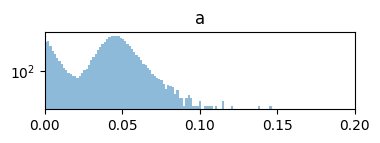

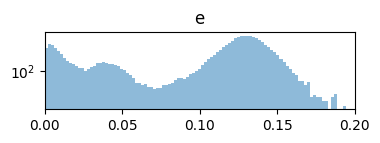

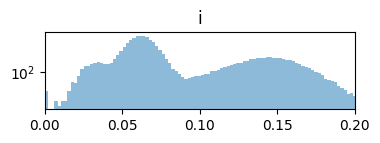

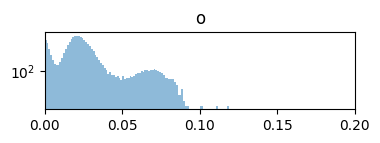

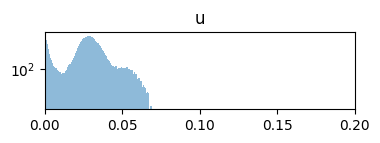

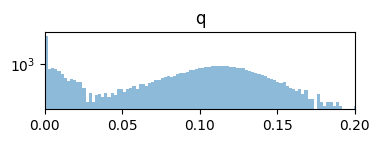

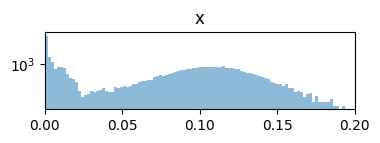

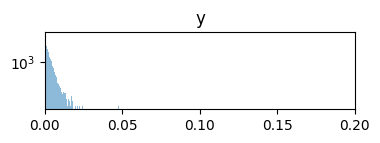

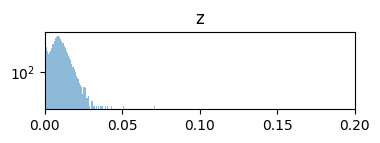

In [12]:
for letter in "aeiouqxyz":
    counts = [a["text"].count(letter) / max(1, len(a["text"])) for a in items]
    plt.hist(counts, bins=100, log=True, alpha=0.5)
    plt.title(letter)
    plt.gcf().set_size_inches(4, 1)
    plt.xlim(0, 0.20)
    plt.show()

In [13]:
abnormal_x = {
    hash(a["text"])
    for a in items
    if a["text"].count("x") / max(1, len(a["text"])) > 0.02
}
abnormal_e = {
    hash(a["text"])
    for a in items
    if a["text"].count("e") / max(1, len(a["text"])) < 0.08
}
abnormal_q = {
    hash(a["text"])
    for a in items
    if a["text"].count("q") / max(1, len(a["text"])) > 0.03
}
abnormal_i = {
    hash(a["text"])
    for a in items
    if a["text"].count("i") / max(1, len(a["text"])) > 0.09
}
len(abnormal_x), len(abnormal_e), len(abnormal_q), len(abnormal_i)

(14920, 17322, 14869, 14825)

In [14]:
intersection = abnormal_x & abnormal_e & abnormal_q
len(intersection)

14860

The texts with abnormalities for any letter seems to be roughly the same for each letter.

In [15]:
len([a for a in items if hash(a["text"]) not in intersection]) / len(items)

0.8820915655002777

In [16]:
len([a for a in items if hash(a["text"]) not in abnormal_e]) / len(items)

0.8625565341585337

In [17]:
filtered_items = [a for a in items if hash(a["text"]) not in abnormal_e]

In [18]:
len(items), len(filtered_items)

(126030, 108708)

In [19]:
len(filtered_items) / len(items)

0.8625565341585337

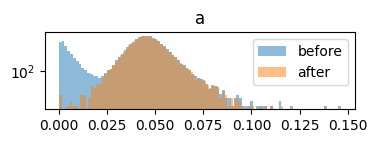

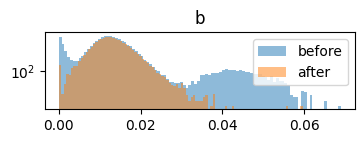

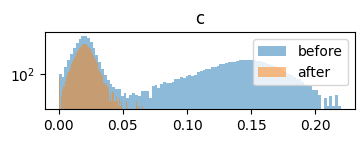

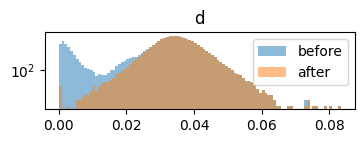

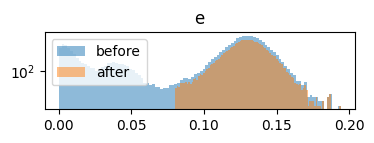

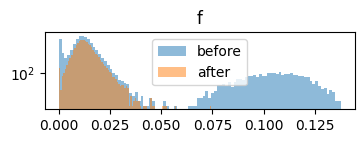

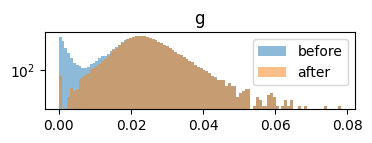

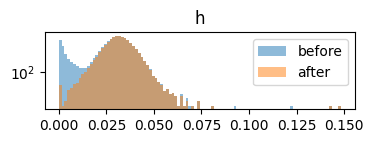

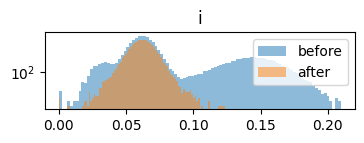

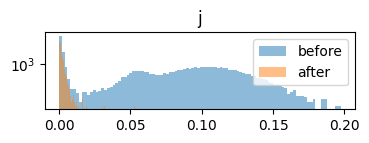

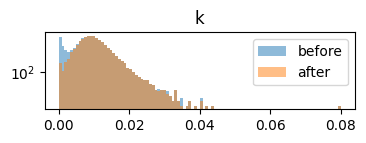

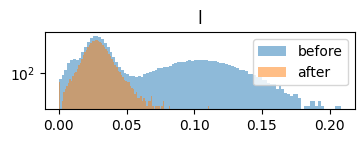

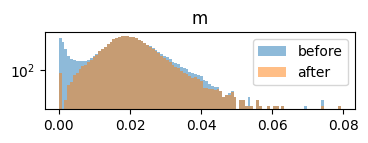

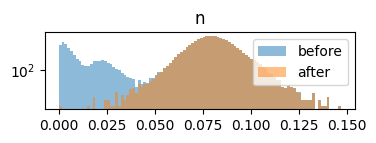

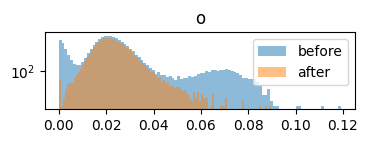

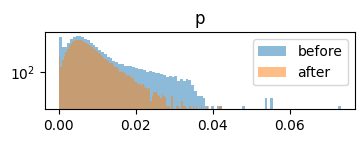

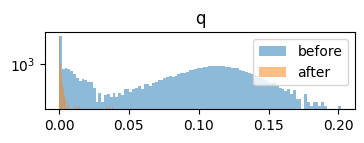

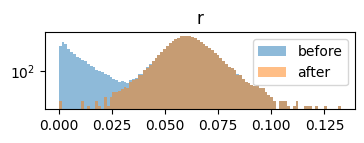

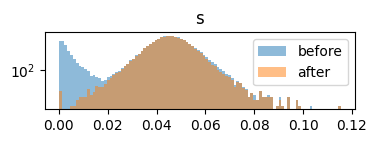

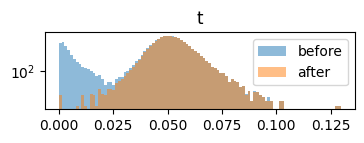

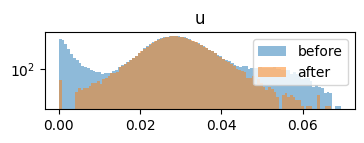

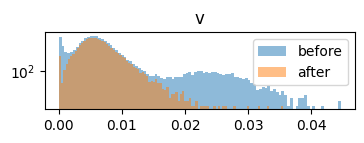

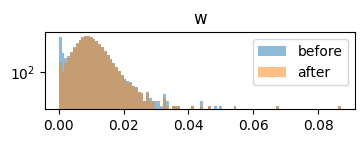

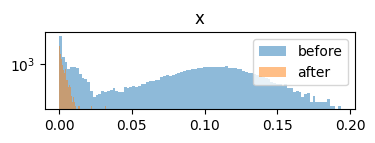

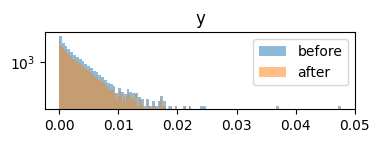

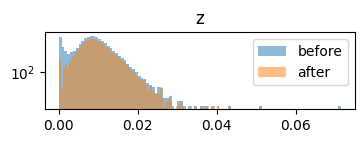

In [20]:
for letter in "abcdefghijklmnopqrstuvwxyz":
    counts_before = [a["text"].count(letter) / max(1, len(a["text"])) for a in items]
    counts_after = [
        a["text"].count(letter) / max(1, len(a["text"])) for a in filtered_items
    ]
    plt.hist(counts_before, bins=100, alpha=0.5, label="before", log=True)
    plt.hist(counts_after, bins=100, alpha=0.5, label="after", log=True)
    plt.legend()
    plt.title(letter)
    plt.gcf().set_size_inches(4, 1)
    # plt.xlim(0, 0.20)
    plt.show()

## Long article problem

"Tickers" concatenate many different pieces of news, some of which might be protest events.

In [21]:
with_ticker = [a for a in items if "Ticker" in a["text"]]

len(with_ticker) / len(items)

0.023478536856304053

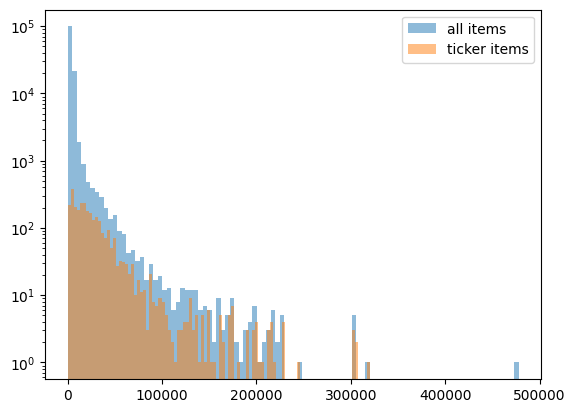

In [22]:
# plot length histograms for with and without ticker
plt.hist(
    [len(a["text"]) for a in items], bins=100, log=True, alpha=0.5, label="all items"
)
plt.hist(
    [len(a["text"]) for a in with_ticker],
    bins=100,
    log=True,
    alpha=0.5,
    label="ticker items",
)
plt.legend()
plt.show()

In [23]:
with_ticker = [a for a in items if "Ticker" in a["text"] or len(a["text"]) > 100_000]

len(with_ticker) / len(items)

0.0239863524557645

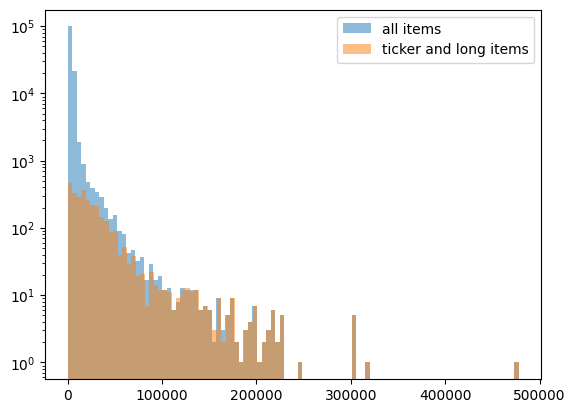

In [24]:
# plot length histograms for with and without ticker
plt.hist(
    [len(a["text"]) for a in items], bins=100, log=True, alpha=0.5, label="all items"
)
plt.hist(
    [len(a["text"]) for a in with_ticker],
    bins=100,
    log=True,
    alpha=0.5,
    label="ticker and long items",
)
plt.legend()
plt.show()

In [25]:
longest_article = max(items, key=lambda a: len(a["text"]))
print(longest_article["meta"]["url"])
print(longest_article["text"][:1000])

https://www.tlz.de/leben/vermischtes/coronavirus-bosch-entwickelt-schnelltest-daimler-beantragt-kurzarbeit-id228762221.html
=vm? =mj?Ebt =tuspoh?Dpspobwjsvt =0tuspoh?csfjufu tjdi jnnfs xfjufs bvt; Xfmuxfju xvsefo nfis bmt 635/111 Jogflujpofo sfhjtusjfsu- gbtu 35/111 Nfotdifo tjoe bo efo Gpmhfo wpo =tuspoh?Dpwje.2:=0tuspoh? hftupscfo´ ýcfs 231/111 Nfotdifo hfmufo bmt hfifjmu=0mj? =mj?Obdi votfsfo Sfdifsdifo tjoe jo Efvutdimboe nfis bmt 54/111 Jogflujpofo obdihfxjftfo- 373 Upuf xvsefo sfhjtusjfsu=0mj? =mj?Cfj 92 Kbisfo mjfhu mbvu SLJ ebt Evsditdiojuutbmufs efs Nfotdifo- ejf jo Efvutdimboe obdi fjofs Jogflujpo nju efn Dpspobwjsvt hftupscfo tjoe=0mj? =mj?Jo efo VTB hjcu ft cfsfjut nfis bmt 2111 Upuf — Ofx Zpsl ibu fjof qspwjtpsjtdif Mfjdifoibmmf fssjdiufu=0mj? =mj?Bvg efn efvutdifo Lsfv{gbisutdijgg NT Bsubojb hjcu ft nfisfsf Dpspob.Jogj{jfsuf=0mj? =mj?Bvdi efs fohmjtdif Uispogpmhfs Qsjo{ Dibsmft ibu tjdi nju efn Wjsvt bohftufdlu=0mj? =mj?Ejf Bcjuvsqsýgvohfo tpmmfo tubuugjoefo — {vn hfqmbou

In [26]:
items_ = items.copy()
items_.remove(longest_article)

 98%|█████████▊| 123151/126029 [00:21<00:00, 5691.81it/s]


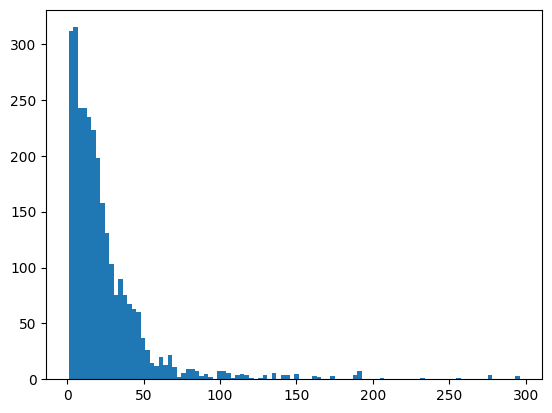

In [27]:
from tqdm import tqdm

ticker_parts = []
n_parts = []
for item in tqdm(items_):
    if "Ticker" in item["text"]:
        n_parts.append(len(item["text"].split("##")))
        for part in item["text"].split("##"):
            item_ = item.copy()
            item_["text"] = "##" + part
            ticker_parts.append(item_)
        items_.remove(item)

# plot histogram of number of parts
plt.hist(n_parts, bins=100)
plt.show()

In [28]:
len(items)

126030

In [29]:
items = items_ + ticker_parts
len(ticker_parts) / len(items), len(items)

(0.3637448593688648, 193556)

Quite a substantial increase! 2% of articles have been tickers and now make up 35% of articles.

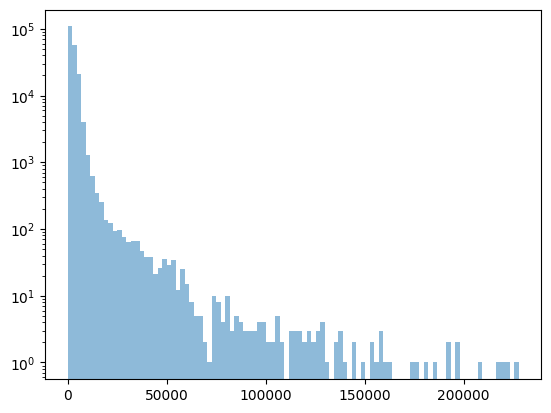

In [30]:
plt.hist(
    [len(a["text"]) for a in items], bins=100, log=True, alpha=0.5, label="all items"
)
plt.show()

In [31]:
import random

random.seed(20230206)
random.shuffle(items)

with open(project_root / "data" / "news" / "protest_news_shuffled_v2.jsonl", "w") as f:
    for item in items:
        item["text"] = f'[{item["meta"]["title"].strip()}]\n\n{item["text"].strip()}'
        f.write(json.dumps(item) + "\n")

In [32]:
from collections import Counter

Counter(item["meta"]["homepage"] for item in items).most_common(30)

[('op-online.de', 23991),
 ('tz.de', 22611),
 ('infranken.de', 20092),
 ('wn.de', 15283),
 ('onetz.de', 14916),
 ('solinger-tageblatt.de', 13639),
 ('zeit.de', 6914),
 ('azonline.de', 6265),
 ('kreiszeitung.de', 5952),
 ('dzonline.de', 5007),
 ('weser-kurier.de', 4873),
 ('wa.de', 4227),
 ('bz-berlin.de', 3638),
 ('lz.de', 3490),
 ('werra-rundschau.de', 3103),
 ('come-on.de', 2887),
 ('muensterschezeitung.de', 2873),
 ('sauerlandkurier.de', 2795),
 ('soester-anzeiger.de', 2745),
 ('augsburger-allgemeine.de', 2719),
 ('wz.de', 2508),
 ('waz-online.de', 2402),
 ('nw.de', 2248),
 ('abendzeitung-muenchen.de', 1962),
 ('idowa.de', 1829),
 ('tlz.de', 1726),
 ('tagesschau.de', 1687),
 ('thueringer-allgemeine.de', 1433),
 ('otz.de', 1302),
 ('die-glocke.de', 1043)]

In [33]:
[
    (item["meta"]["title"], item["meta"]["homepage"])
    for item in items
    if (
        "Letzte Generation" in item["text"]
        or "Letzte Generation" in item["meta"]["title"]
    )
    and item["meta"]["homepage"] == "bz-berlin.de"
]

[]

In [34]:
from os import environ

from dotenv import load_dotenv

from src.data.protests.config import search_string
from src.util.cache import get

load_dotenv()

media_id = 144263

response = get(
    "https://api.mediacloud.org/api/v2/stories_public/list/",
    params={
        "q": f"{search_string[1:]}",
        "fq": f"media_id:{media_id}",
        "rows": 1000,  # max 1000
        "last_processed_stories_id": 0,
        "key": environ["MEDIACLOUD_API_KEY"],
    },
    headers={"Accept": "application/json"},
)
result = response.json()
len(result)

985

In [35]:
from src.data.news.download import get_protest_article_metadata

len(get_protest_article_metadata(media_id))

985
961
1000
715


3661

In [36]:
result